In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [11]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Augmentation

### Define Augmentation Function


In [12]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
angles = [0, 45, 90, 135]

for i in range(len(data)):
    pass

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

In [13]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [14]:
# Preprocessing 1 Ekualisasi Histogram
def histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = np.zeros(256, dtype=int)

    for i in range(baris):
        for j in range(kolom):
            intensitas = int(image[i, j])
            frekuensi_histogram[intensitas] += 1

    return frekuensi_histogram

def equalize_histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = histogram(image)
    probabilitas = frekuensi_histogram / (baris * kolom)
    distribusi_kumulatif = np.zeros(256)
    distribusi_kumulatif[0] = probabilitas[0]
    for i in range(1, 256):
        distribusi_kumulatif[i] = distribusi_kumulatif[i-1] + probabilitas[i]

    image_equalized = np.zeros_like(image)
    for i in range(baris):
        for j in range(kolom):
            intensitas = image[i, j]
            image_equalized[i, j] = int(distribusi_kumulatif[intensitas] * 255)

    return image_equalized

# Preprocessing 2
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

def convolution(image, kernel):
    padding = kernel.shape[0] // 2
    input_image = np.pad(image, padding, mode='constant')

    convolution_image = np.zeros_like(image).astype(np.float32)

    tinggi, lebar = image.shape

    for i in range(tinggi):
        for j in range(lebar):
            convolution_image[i, j] = np.sum(input_image[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return convolution_image

### Preprocessing

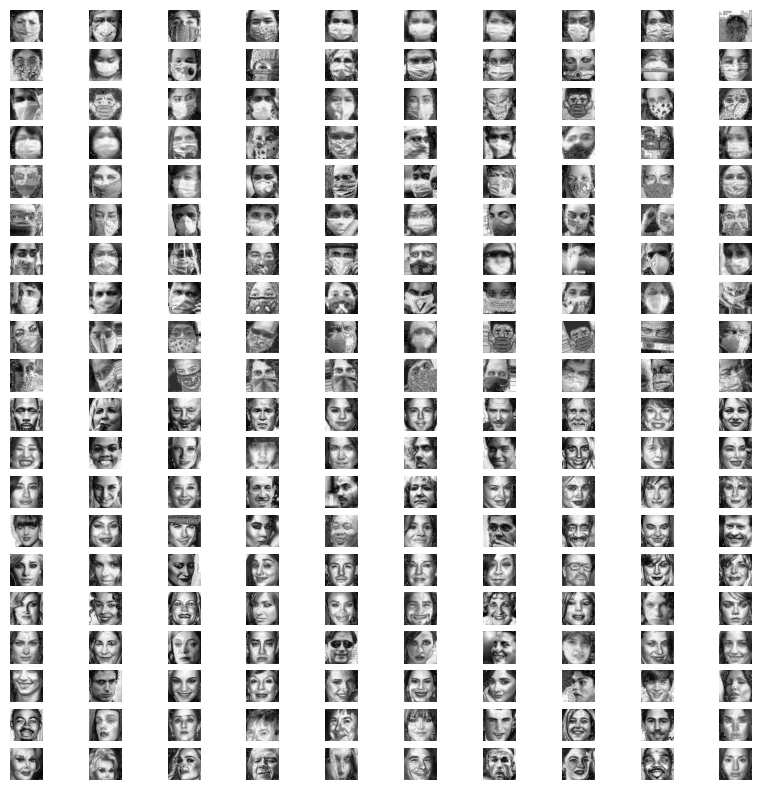

In [15]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
    img = equalize_histogram(data[i])
    img_proc = convolution(img, kernel)
    img_proc = img_proc.astype(np.uint8)
    dataPreprocessed.append(img_proc)

plt.figure(figsize=(10, 10))
for i in range(len(dataPreprocessed)):
    plt.subplot(20, 10, i + 1)
    plt.imshow(dataPreprocessed[i], cmap='gray')
    plt.axis('off')

plt.show()

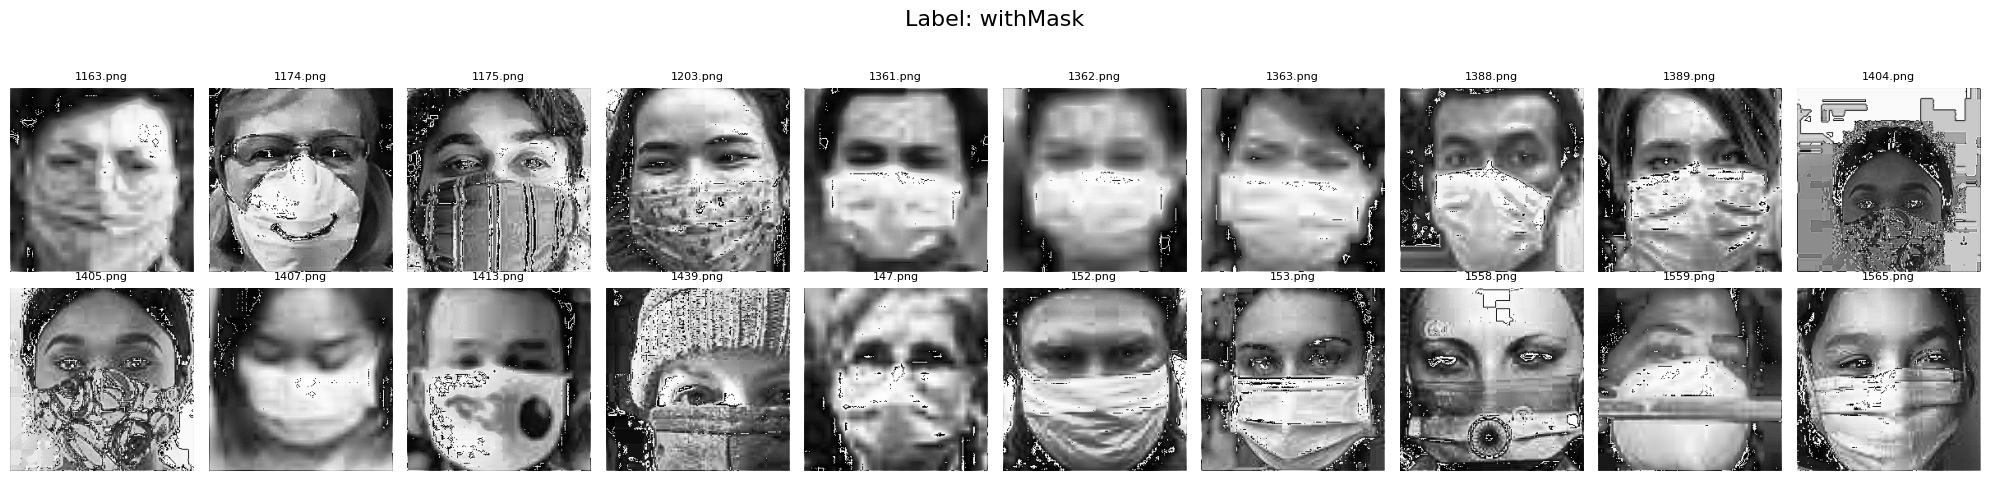

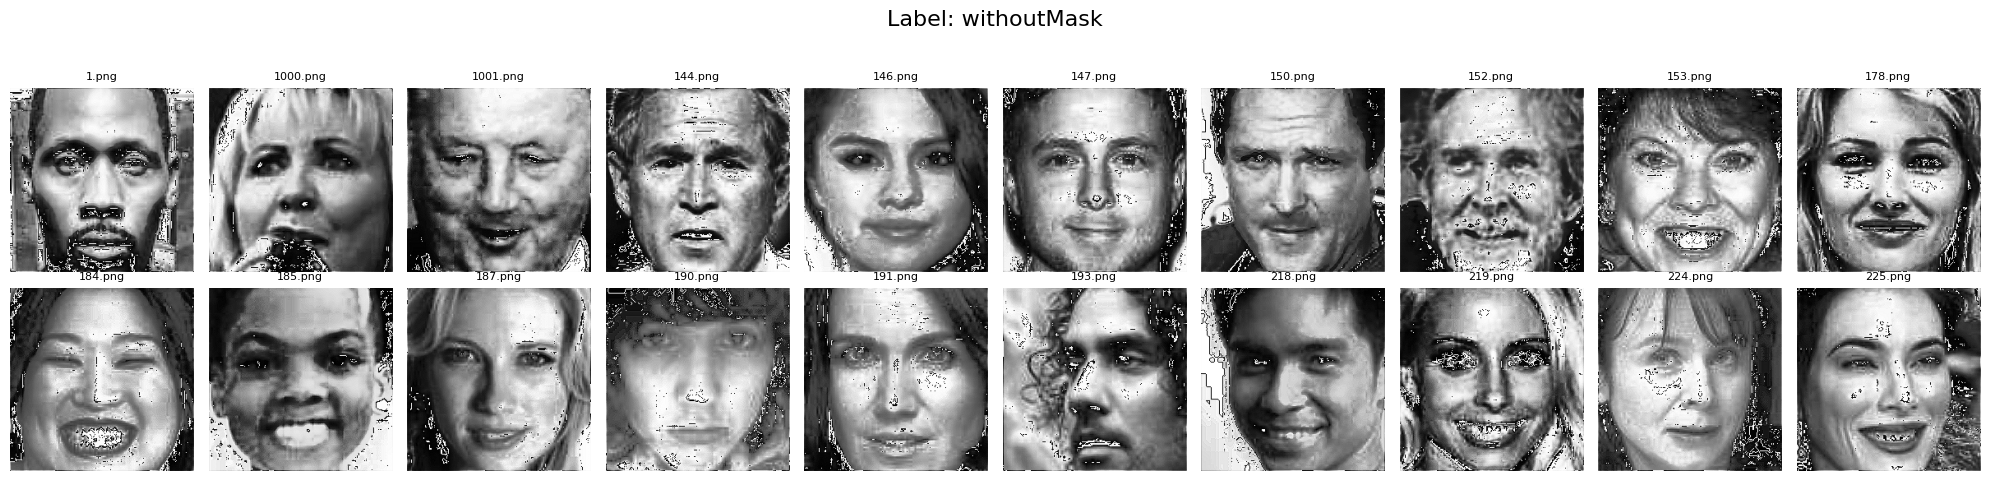

In [16]:
# Konversi ke array
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)
file_name = np.array(file_name)

# Ambil semua label unik
unique_labels = np.unique(labels)

# Tampilkan 20 gambar pertama untuk setiap label
for label in unique_labels:
    # Ambil indeks yang cocok dengan label
    idx = np.where(labels == label)[0][:20]  # ambil 20 pertama saja
    
    # Ukuran figure
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Label: {label}", fontsize=16)

    for i, img_idx in enumerate(idx):
        plt.subplot(2, 10, i+1)
        plt.imshow(dataPreprocessed[img_idx], cmap='gray')
        plt.title(file_name[img_idx], fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

### Feature Extraction

In [17]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [18]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [19]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [20]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [21]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [22]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [23]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [24]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [25]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [26]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [27]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [28]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [29]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [30]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [31]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [32]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [33]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [34]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1163.png,withMask,627.540839,717.724668,657.426650,749.376018,0.199080,0.173577,0.202737,0.167976,...,0.000231,0.000187,0.014981,0.013877,0.015198,0.013661,0.942479,0.934228,0.939668,0.931329
1,1174.png,withMask,1571.820988,1952.746808,1718.126041,1949.024955,0.174246,0.143632,0.173615,0.144357,...,0.000179,0.000147,0.013714,0.012118,0.013376,0.012113,0.865333,0.832665,0.853196,0.832977
2,1175.png,withMask,3897.208040,4266.582256,2374.989150,4258.781938,0.114784,0.091713,0.137661,0.091258,...,0.000132,0.000083,0.010114,0.009112,0.011478,0.009108,0.662628,0.630438,0.794612,0.631110
3,1203.png,withMask,1917.831819,2414.635364,1812.316604,2359.935350,0.141646,0.104028,0.129383,0.104475,...,0.000132,0.000104,0.011889,0.010114,0.011494,0.010196,0.831541,0.787912,0.841022,0.792714
4,1361.png,withMask,639.288997,805.408615,636.693286,813.401054,0.216646,0.179471,0.203283,0.177845,...,0.000247,0.000213,0.016294,0.014633,0.015724,0.014600,0.942258,0.927323,0.942576,0.926604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,967.png,withoutMask,998.210222,1265.099942,1167.940403,1309.528565,0.203230,0.181248,0.230279,0.177080,...,0.002972,0.002546,0.051326,0.050732,0.054515,0.050455,0.908099,0.883631,0.892416,0.879544
196,972.png,withoutMask,2679.923907,3273.538458,2212.095151,3269.791510,0.117695,0.091784,0.120953,0.092288,...,0.000128,0.000095,0.011032,0.009715,0.011317,0.009740,0.772995,0.722810,0.812599,0.723126
197,973.png,withoutMask,2091.455257,2392.733576,1965.824251,2351.740835,0.127644,0.102834,0.129327,0.102173,...,0.000139,0.000110,0.011671,0.010473,0.011785,0.010503,0.819109,0.793057,0.829951,0.796607
198,998.png,withoutMask,3221.287676,3882.035050,2868.893658,3913.794667,0.117887,0.101485,0.131146,0.100296,...,0.000298,0.000229,0.016086,0.015249,0.017269,0.015144,0.732742,0.678347,0.761624,0.675716


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

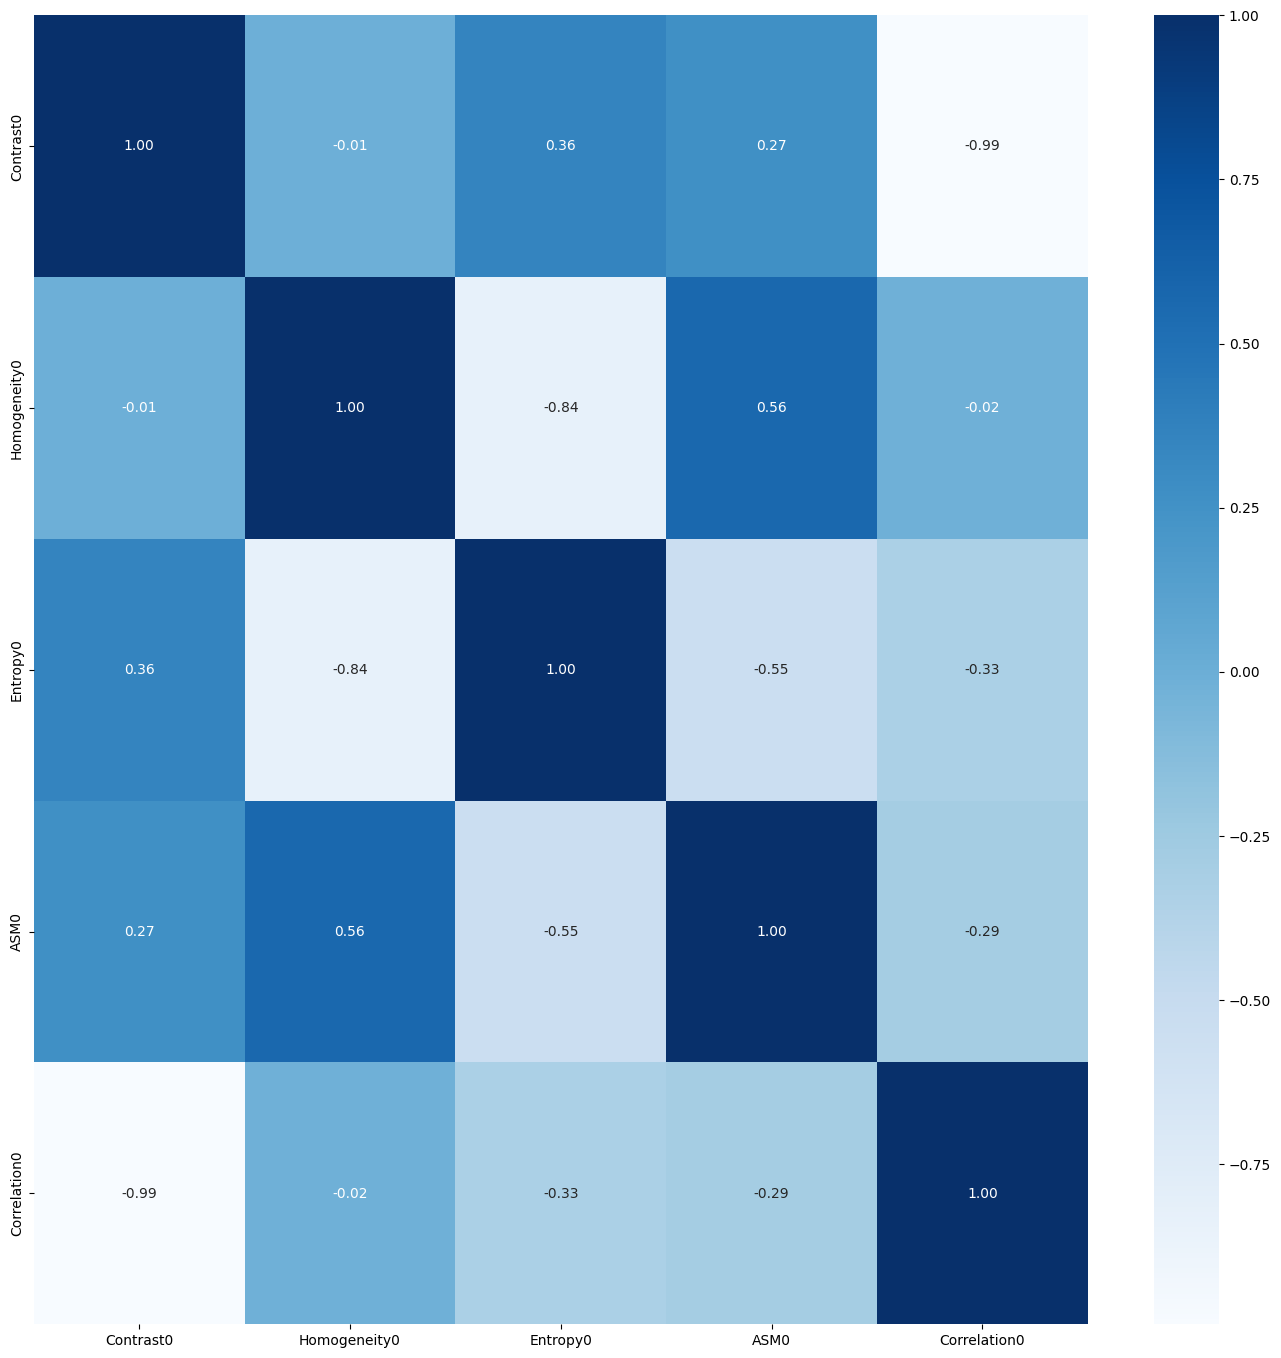

In [35]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [36]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 5)
(40, 5)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [37]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [38]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [39]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

    withMask       0.93      1.00      0.96        79
 withoutMask       1.00      0.93      0.96        81

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.97      0.96      0.96       160

[[79  0]
 [ 6 75]]
Accuracy: 0.9625

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.71      0.95      0.82        21
 withoutMask       0.92      0.58      0.71        19

    accuracy                           0.78        40
   macro avg       0.82      0.77      0.76        40
weighted avg       0.81      0.78      0.77        40

[[20  1]
 [ 8 11]]
Accuracy: 0.775


### Train SVM Classifier

In [40]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

    withMask       0.90      0.78      0.84        79
 withoutMask       0.81      0.91      0.86        81

    accuracy                           0.85       160
   macro avg       0.86      0.85      0.85       160
weighted avg       0.86      0.85      0.85       160

[[62 17]
 [ 7 74]]
Accuracy: 0.85

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.86      0.90      0.88        21
 withoutMask       0.89      0.84      0.86        19

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[19  2]
 [ 3 16]]
Accuracy: 0.875


### Train KNN Classifier

In [41]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

    withMask       0.92      0.82      0.87        79
 withoutMask       0.84      0.93      0.88        81

    accuracy                           0.88       160
   macro avg       0.88      0.87      0.87       160
weighted avg       0.88      0.88      0.87       160

[[65 14]
 [ 6 75]]
Accuracy: 0.875

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.83      0.90      0.86        21
 withoutMask       0.88      0.79      0.83        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[19  2]
 [ 4 15]]
Accuracy: 0.85


## Evaluation With Confusion Matrix

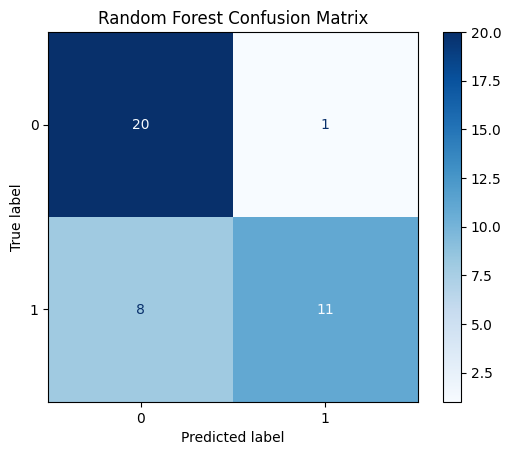

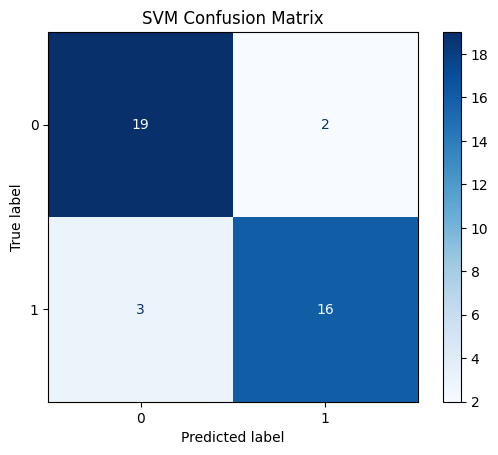

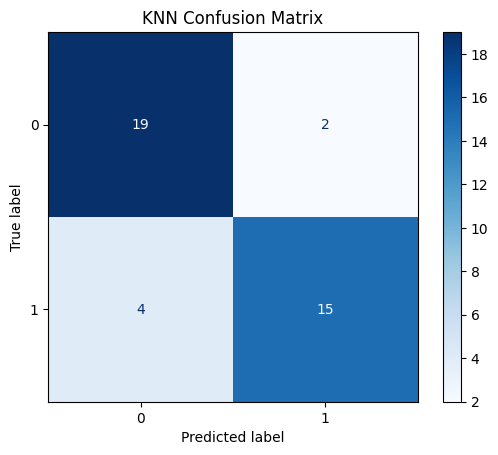

In [42]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")